# Задача 1. 

Давайте решим задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

Оценивать качество мы будем с помощью ROC-AUC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать: 

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов: 
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, classification_report
import seaborn as sns

In [2]:
data = pd.read_csv('data.adult.csv')
data.sample(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
3808,49,Private,227800,7th-8th,4,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,32,<=50K
10540,26,Private,245880,HS-grad,9,Never-married,Adm-clerical,Not-in-family,White,Male,0,0,60,<=50K
1081,20,Private,411862,Assoc-voc,11,Never-married,Other-service,Not-in-family,White,Male,0,0,30,<=50K
3282,54,State-gov,32778,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,0,40,<=50K
4016,62,Self-emp-not-inc,71467,Bachelors,13,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,55,>50K
12565,19,Private,159313,HS-grad,9,Never-married,Handlers-cleaners,Not-in-family,White,Male,0,0,40,<=50K
11399,25,Private,222539,10th,6,Never-married,Transport-moving,Not-in-family,White,Male,2597,0,50,<=50K
6251,29,Private,149211,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,<=50K
7215,17,Self-emp-not-inc,228786,10th,6,Never-married,Other-service,Own-child,White,Female,0,0,24,<=50K
4506,50,Self-emp-not-inc,29231,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,>50K


In [3]:
data.dtypes  # понадобится потом, чтобы отделить нечисловые признаки

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
>50K,<=50K        object
dtype: object

Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). 

В данном датасете пропущенные значения обозначены как "?". 

Найдем все признаки, имеющие пропущенные значения. Удалим из выборки все объекты с пропусками.

In [4]:
data.isin(['?']).any()

age               False
workclass          True
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation         True
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
>50K,<=50K        False
dtype: bool

workclass & occupation содержат пропущенные значения. 

In [5]:
data = data[(data.workclass != '?') & (data.occupation != '?')].copy()

In [6]:
data.isin(['?']).any()

age               False
workclass         False
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation        False
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
>50K,<=50K        False
dtype: bool

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 

 - Выделим целевую переменную в отдельную переменную, удалим ее из датасета и преобразуем к бинарному формату.
 - Не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. 

Преобразовываем в бинарный формат:

In [7]:
data['>50K,<=50K'] = data['>50K,<=50K'].apply(lambda x: 1 if x == '>50K' else -1)
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,-1
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,-1
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,-1
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,-1
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,1


In [8]:
print(f"{set(data['workclass'])}\n{set(data['education'])}\n{set(data['marital-status'])}\n{set(data['occupation'])}\n{set(data['relationship'])}\n{set(data['race'])}\n{set(data['sex'])}")

{'Private', 'Local-gov', 'Self-emp-inc', 'State-gov', 'Federal-gov', 'Self-emp-not-inc', 'Without-pay'}
{'11th', 'Preschool', '1st-4th', '5th-6th', 'Doctorate', '12th', 'Bachelors', '9th', 'Assoc-voc', 'Prof-school', 'Masters', 'Assoc-acdm', '10th', '7th-8th', 'Some-college', 'HS-grad'}
{'Married-spouse-absent', 'Divorced', 'Never-married', 'Widowed', 'Married-AF-spouse', 'Married-civ-spouse', 'Separated'}
{'Prof-specialty', 'Tech-support', 'Handlers-cleaners', 'Farming-fishing', 'Transport-moving', 'Exec-managerial', 'Armed-Forces', 'Sales', 'Machine-op-inspct', 'Craft-repair', 'Other-service', 'Priv-house-serv', 'Protective-serv', 'Adm-clerical'}
{'Other-relative', 'Not-in-family', 'Unmarried', 'Own-child', 'Wife', 'Husband'}
{'Asian-Pac-Islander', 'Other', 'Black', 'White', 'Amer-Indian-Eskimo'}
{'Female', 'Male'}


In [9]:
categ_columns = data.select_dtypes(['object']).columns  
data[categ_columns] = data[categ_columns].apply (lambda x: pd.factorize(x)[0])

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15347 entries, 0 to 16279
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             15347 non-null  int64
 1   workclass       15347 non-null  int64
 2   fnlwgt          15347 non-null  int64
 3   education       15347 non-null  int64
 4   education-num   15347 non-null  int64
 5   marital-status  15347 non-null  int64
 6   occupation      15347 non-null  int64
 7   relationship    15347 non-null  int64
 8   race            15347 non-null  int64
 9   sex             15347 non-null  int64
 10  capital-gain    15347 non-null  int64
 11  capital-loss    15347 non-null  int64
 12  hours-per-week  15347 non-null  int64
 13  >50K,<=50K      15347 non-null  int64
dtypes: int64(14)
memory usage: 1.8 MB


Выделим целевую переменную в y, числовые признаки - в Х

In [11]:
X = data.drop('>50K,<=50K', axis=1)
y = data['>50K,<=50K']

X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week
0,34,0,284843,0,9,0,0,0,0,0,594,0,60
1,40,1,190290,1,10,1,1,0,1,0,0,0,40
2,36,0,177858,2,13,2,2,1,1,0,0,0,40
3,22,1,184756,1,10,0,1,1,1,1,0,0,30
4,47,1,149700,2,13,2,3,2,1,0,15024,0,40


Разобьем Х на тест и трейн

In [12]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=42)

<Axes: >

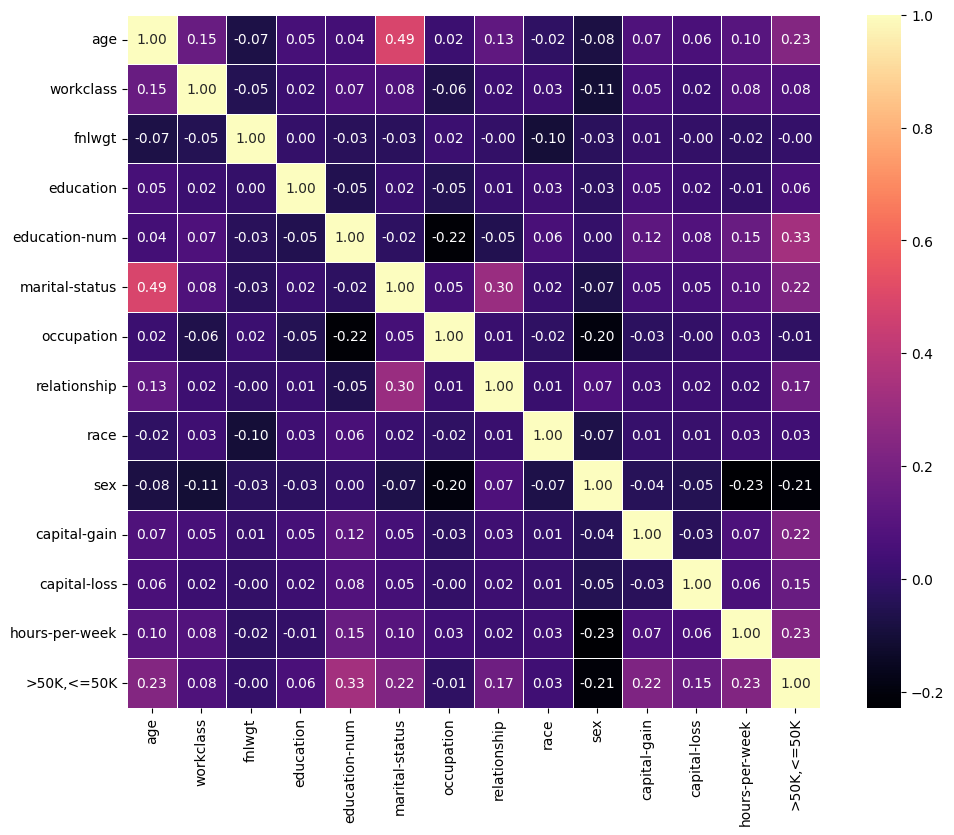

In [27]:
plt.figure(figsize=(12, 9))

corr = data.corr()

sns.heatmap(corr,annot=True,linewidths=.5,fmt= '.2f',\
            mask = np.zeros_like(corr, dtype=bool), \
            cmap = sns.color_palette('magma', as_cmap=True), square=True)

## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - kNN
 - SGD Linear Classifier (SVС со стохастическим градиентным спуском)
 - Naive Bayes Classifier
 - Logistic Regression
 - SVC (Support Vector Classifier)
 
Для начала у первых двух алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)
 
Остальные параметры будем оставлять в значениях по умолчанию. Для подбора гиперпараметров воспользуемся перебором по сетке, который реализован в классе GridSearchCV. В качестве схемы кросс-валидации будем использовать 5-fold cv.

Для каждого из первых двух алгоритмов подберем оптимальные значения указанных гиперпараметров. Построим график среднего качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразим доверительный интервал (доверительный интервал задается границами [mean - std, mean + std]).

In [13]:
def plotting(grid, params):
    """Функция для построения графиков"""
    scores_mean = grid.cv_results_['mean_test_score']
    scores_sd = grid.cv_results_['std_test_score']

    fig, ax = plt.subplots()
    ax.plot(params,scores_mean)
    ax.fill_between(params, (scores_mean-scores_sd), (scores_mean+scores_sd), color='g', alpha=.1)

In [14]:
def model_train(model, param_grid, hyperparams):
    """Функция подбора гиперпараметров, вызывает функцию с графиками"""
    grid = GridSearchCV(model, param_grid, scoring='roc_auc')  # если не передавать cv явно, как раз будет использована 5-fold cv
    grid.fit(Xtrain, ytrain)
    plotting(grid, hyperparams)
    print(f'Best params: {grid.best_params_}')
    best = grid.best_estimator_
    y_pred_train = best.predict(Xtrain)
    y_pred_test = best.predict(Xtest)
    print(classification_report(ytrain, y_pred_train), classification_report(ytest, y_pred_test))
    print(roc_auc_score(ytrain, y_pred_train), roc_auc_score(ytest, y_pred_test))

**KNN Classifier**

In [15]:
model = KNeighborsClassifier()
hyperparams = list(range(2, 30)) # k=2 до k=30
param_grid = {'n_neighbors': hyperparams}

KNN results
Best params: {'n_neighbors': 3}
              precision    recall  f1-score   support

          -1       0.86      0.95      0.90      8550
           1       0.78      0.57      0.66      2960

    accuracy                           0.85     11510
   macro avg       0.82      0.76      0.78     11510
weighted avg       0.84      0.85      0.84     11510
               precision    recall  f1-score   support

          -1       0.79      0.86      0.83      2857
           1       0.46      0.34      0.39       980

    accuracy                           0.73      3837
   macro avg       0.63      0.60      0.61      3837
weighted avg       0.71      0.73      0.72      3837

0.7586113086770981 0.6013241733515247


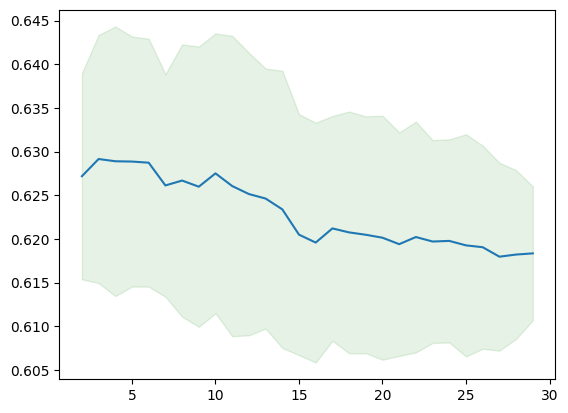

In [16]:
print('KNN results')
model_train(model, param_grid, hyperparams)

Попробуем нормализовать

In [18]:
model = Pipeline([
    ('scale', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
#make_pipeline(...)
#'kneighborsclassifier__n_neighbors'
hyperparams = list(range(2, 30))
param_grid = {'knn__n_neighbors': hyperparams}

Normalised KNN results
Best params: {'knn__n_neighbors': 29}
              precision    recall  f1-score   support

          -1       0.87      0.93      0.89      8550
           1       0.73      0.59      0.65      2960

    accuracy                           0.84     11510
   macro avg       0.80      0.76      0.77     11510
weighted avg       0.83      0.84      0.83     11510
               precision    recall  f1-score   support

          -1       0.85      0.92      0.88      2857
           1       0.69      0.53      0.60       980

    accuracy                           0.82      3837
   macro avg       0.77      0.72      0.74      3837
weighted avg       0.81      0.82      0.81      3837

0.7566674569306148 0.7248791010979121


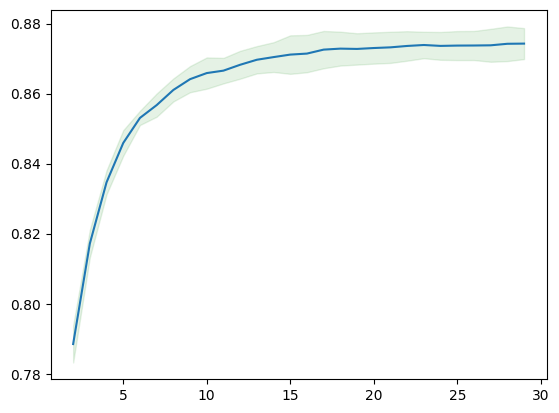

In [19]:
print('Normalised KNN results')
model_train(model, param_grid, hyperparams)

**SGDClassifier**

In [28]:
model = SGDClassifier()
hyperparams = ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron']
param_grid = {'loss': hyperparams}

SGD results
Best params: {'loss': 'perceptron'}
              precision    recall  f1-score   support

          -1       0.77      0.99      0.87      8550
           1       0.80      0.16      0.26      2960

    accuracy                           0.77     11510
   macro avg       0.78      0.57      0.56     11510
weighted avg       0.78      0.77      0.71     11510
               precision    recall  f1-score   support

          -1       0.78      0.99      0.87      2857
           1       0.88      0.17      0.29       980

    accuracy                           0.78      3837
   macro avg       0.83      0.58      0.58      3837
weighted avg       0.80      0.78      0.72      3837

0.5716467125019756 0.5821992885358553


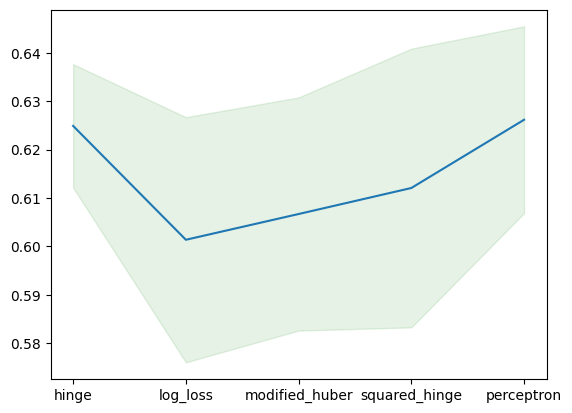

In [29]:
print('SGD results')
model_train(model, param_grid, hyperparams)

Попробуем нормализовать

In [30]:
model = Pipeline([
    ('scale', StandardScaler()),
    ('sgd', SGDClassifier())
])
hyperparams = ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron']
param_grid = {'sgd__loss': hyperparams}

Normalised SGD results
Best params: {'sgd__loss': 'log_loss'}
              precision    recall  f1-score   support

          -1       0.83      0.95      0.89      8550
           1       0.75      0.45      0.56      2960

    accuracy                           0.82     11510
   macro avg       0.79      0.70      0.72     11510
weighted avg       0.81      0.82      0.80     11510
               precision    recall  f1-score   support

          -1       0.83      0.95      0.89      2857
           1       0.75      0.44      0.55       980

    accuracy                           0.82      3837
   macro avg       0.79      0.69      0.72      3837
weighted avg       0.81      0.82      0.80      3837

0.699288367314683 0.6940263084582801


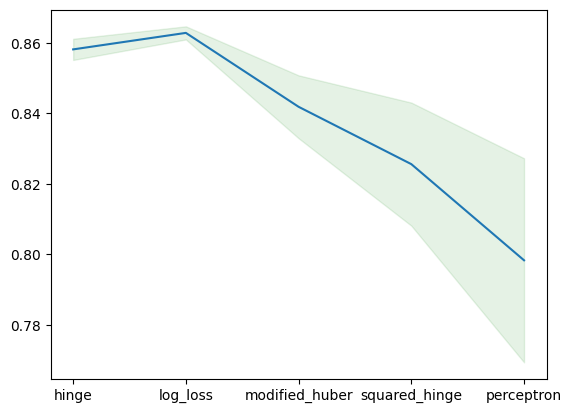

In [31]:
print('Normalised SGD results')
model_train(model, param_grid, hyperparams)

hinge - это SVM, log - логистическая регрессия, modified_huber - сглаженный SVM, squared_hinge - SVM, который штрафуется квадратично, perceptron - алгоритм перцептрона (Розенблатт). 

Гиперпараметры для остальных алгоритмов попробуйте подобрать сами. Нам осталось посмотреть:

- LogisticRegression
- SVC
- Naive Bayes

LogiscticRegression

In [39]:
model = LogisticRegression(solver='liblinear')
hyperparams = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'C': hyperparams}

LogisticRegression results
Best params: {'C': 0.001}
              precision    recall  f1-score   support

          -1       0.79      0.96      0.87      8550
           1       0.70      0.27      0.39      2960

    accuracy                           0.78     11510
   macro avg       0.74      0.61      0.63     11510
weighted avg       0.77      0.78      0.74     11510
               precision    recall  f1-score   support

          -1       0.80      0.97      0.87      2857
           1       0.74      0.28      0.41       980

    accuracy                           0.79      3837
   macro avg       0.77      0.62      0.64      3837
weighted avg       0.78      0.79      0.76      3837

0.6148427374743164 0.6246858771510004


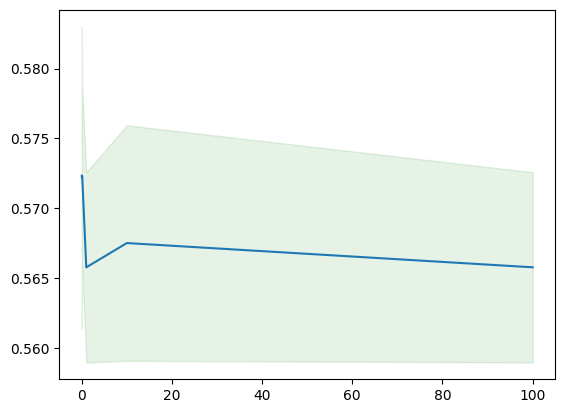

In [40]:
print('LogisticRegression results')
model_train(model, param_grid, hyperparams)

In [47]:
model = LogisticRegression(C=0.001, max_iter=1500)
hyperparams = ['liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
param_grid = {'solver': hyperparams}

LogisticRegression results


d:\python39\lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
d:\python39\lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
d:\python39\lib\site-packages\scipy\optimize\_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
d:\python39\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
d:\python39\lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
d:\python39\lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search a

Best params: {'solver': 'newton-cholesky'}
              precision    recall  f1-score   support

          -1       0.83      0.95      0.88      8550
           1       0.74      0.44      0.55      2960

    accuracy                           0.82     11510
   macro avg       0.78      0.69      0.72     11510
weighted avg       0.81      0.82      0.80     11510
               precision    recall  f1-score   support

          -1       0.83      0.95      0.88      2857
           1       0.74      0.43      0.54       980

    accuracy                           0.82      3837
   macro avg       0.79      0.69      0.71      3837
weighted avg       0.81      0.82      0.80      3837

0.6939803619408882 0.6875538419778131


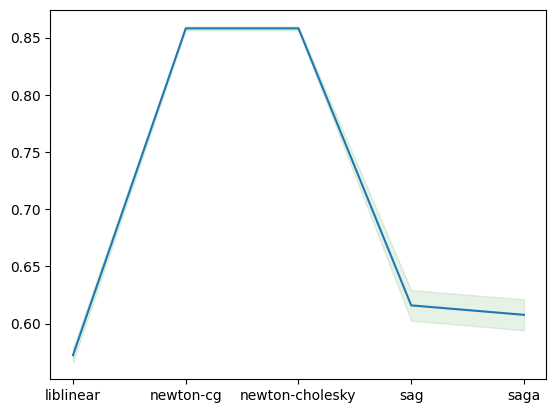

In [48]:
print('LogisticRegression results')
model_train(model, param_grid, hyperparams)

In [49]:
model = LogisticRegression(max_iter=1500, solver='newton-cholesky', class_weight='balanced')
hyperparams = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'C': hyperparams}

LogisticRegression results
Best params: {'C': 0.1}
              precision    recall  f1-score   support

          -1       0.91      0.78      0.84      8550
           1       0.55      0.78      0.65      2960

    accuracy                           0.78     11510
   macro avg       0.73      0.78      0.74     11510
weighted avg       0.82      0.78      0.79     11510
               precision    recall  f1-score   support

          -1       0.90      0.77      0.83      2857
           1       0.53      0.76      0.63       980

    accuracy                           0.77      3837
   macro avg       0.72      0.77      0.73      3837
weighted avg       0.81      0.77      0.78      3837

0.7794685474948633 0.7655157757887894


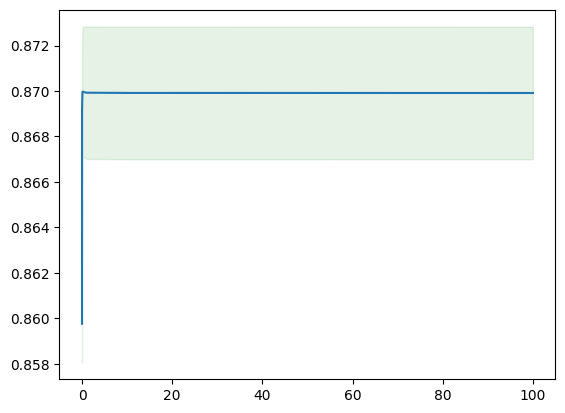

In [50]:
print('LogisticRegression results')
model_train(model, param_grid, hyperparams)

LinearSVC

In [51]:
from sklearn.svm import LinearSVC

In [54]:
model = LinearSVC(random_state=0, tol=1e-5, verbose=3, max_iter=1000, dual=False)
hyperparams = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'C': hyperparams}

LinearSVC results
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best params: {'C': 10}
              precision    recall  f1-score   support

          -1       0.79      0.96      0.87      8550
           1       0.73      0.28      0.40      2960

    accuracy                           0.79     11510
   macro avg       0.76      0.62      0.64     11510
weighted avg       0.78      0.79      0.75     11510
               precision    recall  f1-score   support

          -1       0.80      0.97      0.88      2857
           1       0.76      0.29      0.42       980

    accuracy                           0.80      3837
   macro avg       0.78      0.63      0.65      3837
weighted avg       

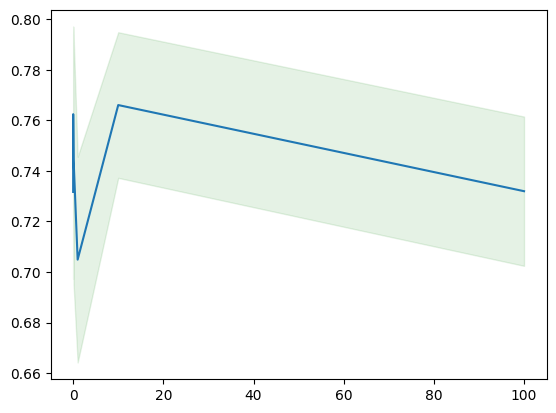

In [55]:
print('LinearSVC results')
model_train(model, param_grid, hyperparams)

Naive Bayes

In [58]:
model = GaussianNB()
hyperparams = [1e-9, 1e-6, 1e-12]
param_grid = {'var_smoothing': hyperparams}

GaussianNB results
Best params: {'var_smoothing': 1e-12}
              precision    recall  f1-score   support

          -1       0.80      0.94      0.87      8550
           1       0.67      0.32      0.44      2960

    accuracy                           0.78     11510
   macro avg       0.73      0.63      0.65     11510
weighted avg       0.77      0.78      0.76     11510
               precision    recall  f1-score   support

          -1       0.81      0.95      0.87      2857
           1       0.70      0.34      0.46       980

    accuracy                           0.79      3837
   macro avg       0.76      0.65      0.67      3837
weighted avg       0.78      0.79      0.77      3837

0.6341439465781571 0.6457319294536155


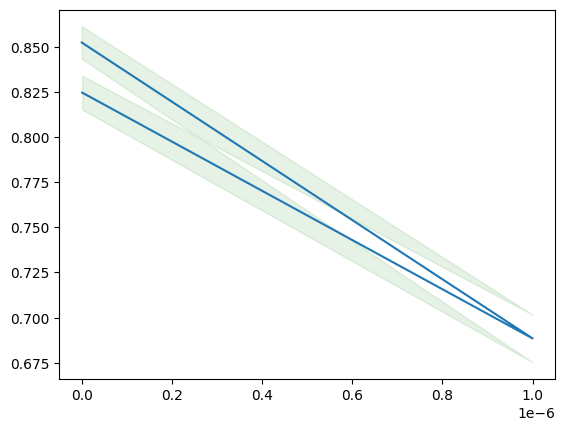

In [59]:
print('GaussianNB results')
model_train(model, param_grid, hyperparams)

Также можете попробовать поработать с категориальными признаками. 

In [ ]:
# fnlwgt education occupation race workclass низкая корреляция
# marital-status коррелирует с age

In [62]:
data.drop(['marital-status', 'fnlwgt', 'education', 'occupation', 'race', 'workclass'], axis= 1, inplace= True) 

In [66]:
# у этой модели был лучший результат, поэтому решила её ещё раз обучить
model = LogisticRegression(max_iter=1500, solver='newton-cholesky', class_weight='balanced')
hyperparams = [0.1]
param_grid = {'C': hyperparams}

LogisticRegression results
Best params: {'C': 0.1}
              precision    recall  f1-score   support

          -1       0.91      0.78      0.84      8550
           1       0.55      0.78      0.65      2960

    accuracy                           0.78     11510
   macro avg       0.73      0.78      0.74     11510
weighted avg       0.82      0.78      0.79     11510
               precision    recall  f1-score   support

          -1       0.90      0.77      0.83      2857
           1       0.53      0.76      0.63       980

    accuracy                           0.77      3837
   macro avg       0.72      0.77      0.73      3837
weighted avg       0.81      0.77      0.78      3837

0.7794685474948633 0.7655157757887894


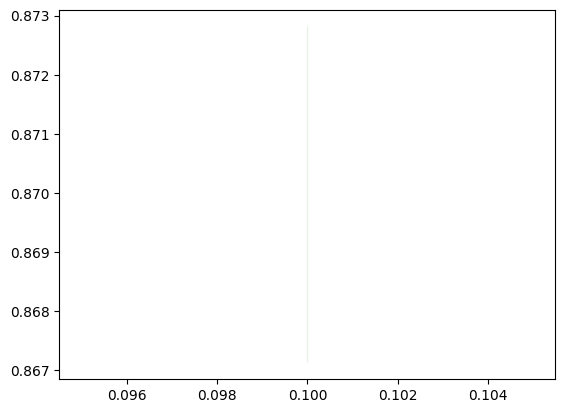

In [67]:
print('LogisticRegression results')
model_train(model, param_grid, hyperparams)

Почему-то вообще ничего не изменилось

In [68]:
data.drop('capital-loss', axis=1, inplace=True) 

In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15347 entries, 0 to 16279
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             15347 non-null  int64
 1   education-num   15347 non-null  int64
 2   relationship    15347 non-null  int64
 3   sex             15347 non-null  int64
 4   capital-gain    15347 non-null  int64
 5   hours-per-week  15347 non-null  int64
 6   >50K,<=50K      15347 non-null  int64
dtypes: int64(7)
memory usage: 959.2 KB


In [73]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(Xtrain)
X_test_scaled = scaler.transform(Xtest)
 
# гиперпараметры
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],     
}
 
logistic_regression = LogisticRegression(max_iter=1500, solver='newton-cholesky', class_weight='balanced')
 
grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, ytrain)
 
# лучшие гиперпараметры
best_params = grid_search.best_params_
 
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, ytrain)

accuracy = best_model.score(X_test_scaled, ytest)
print(f'Best Hyperparameters: {best_params}')
print(f'Accuracy on test set: {accuracy:.2f}')

Best Hyperparameters: {'C': 10}
Accuracy on test set: 0.77
